In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('retina')
plt.style.use('ggplot')

from models.RL import rl_utils, nets, bb_net_rl

import torch

In [2]:
mushroom_df = pd.read_csv('mushroom.csv')
mushroom_df = mushroom_df.sample(frac=1, random_state=42)
mushroom_df.head()

,cap-shape,cap-surface,cap-color,bruises%3F,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
1971,f,f,n,f,n,f,w,b,h,t,...,w,w,p,w,o,e,n,s,g,e
6654,f,s,e,f,y,f,c,n,b,t,...,p,p,p,w,o,e,w,v,l,p
5606,x,y,n,f,f,f,c,n,b,t,...,w,p,p,w,o,e,w,v,l,p
3332,f,y,g,t,n,f,c,b,n,t,...,g,p,p,w,o,p,n,y,d,e
6988,f,s,e,f,s,f,c,n,b,t,...,p,p,p,w,o,e,w,v,l,p


In [3]:
for c in mushroom_df.columns:
    mushroom_df[c] = mushroom_df[c].astype('category').cat.codes
mushroom_df.head() # 1: poisonous, 2: edible

,cap-shape,cap-surface,cap-color,bruises%3F,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
1971,2,0,4,0,5,1,1,0,3,1,...,7,7,0,2,1,0,3,3,1,0
6654,2,2,2,0,8,1,0,1,0,1,...,6,6,0,2,1,0,7,4,2,1
5606,5,3,4,0,2,1,0,1,0,1,...,7,6,0,2,1,0,7,4,2,1
3332,2,3,3,1,5,1,0,0,5,1,...,3,6,0,2,1,4,3,5,0,0
6988,2,2,2,0,7,1,0,1,0,1,...,6,6,0,2,1,0,7,4,2,1


In [4]:
train_size = int(0.8 * len(mushroom_df))
train_df, test_df = mushroom_df[:train_size], mushroom_df[train_size:]

In [5]:
train_X, train_y = train_df.iloc[:, :-1].to_numpy(), train_df['class'].to_numpy()
test_X, test_y = test_df.iloc[:, :-1].to_numpy(), test_df['class'].to_numpy()
dim_input = train_X.shape[1]
dim_action_space = 2

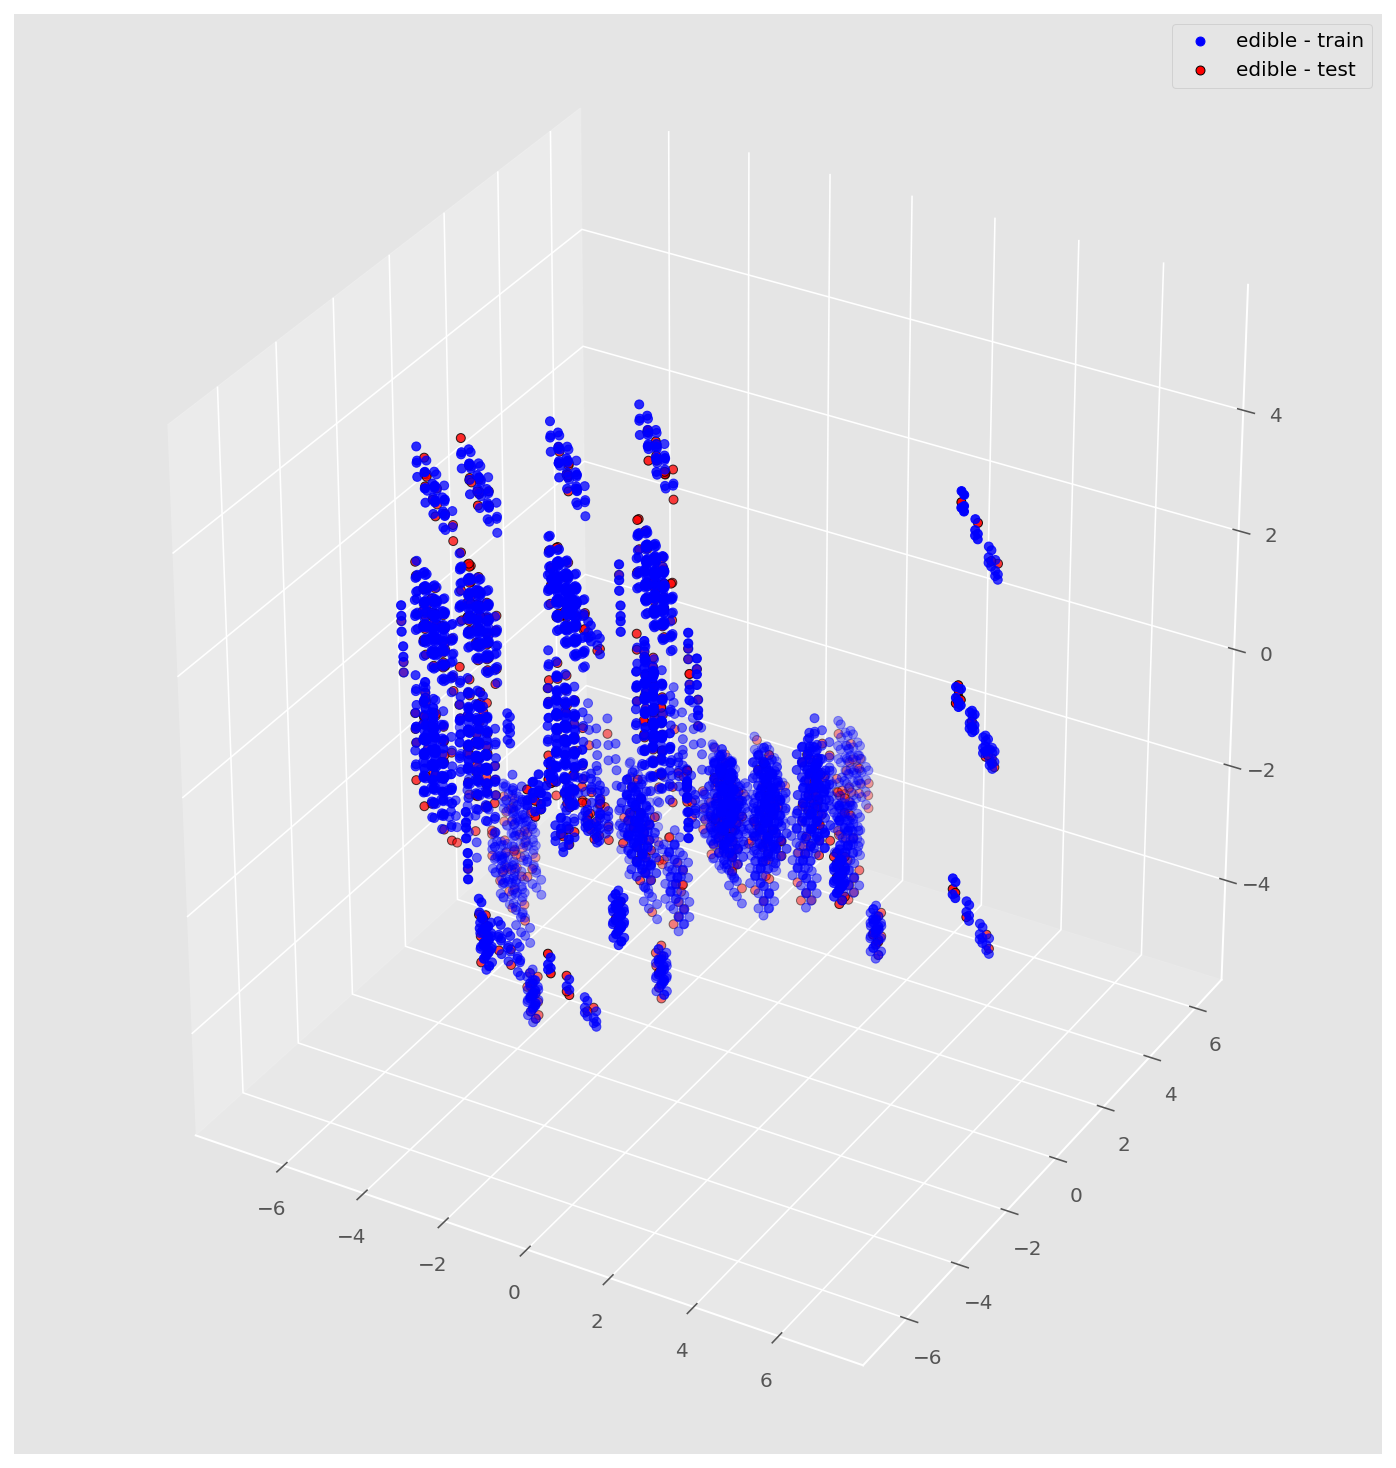

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import decomposition
from sklearn import datasets



fig = plt.figure(1, figsize=(10, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1])  #, elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(mushroom_df.iloc[:, :-1].to_numpy())
X = pca.transform(train_X)

edible = mushroom_df['class'] == 0
ax.scatter(X[edible[:len(X)], 0], X[edible[:len(X)], 1], X[edible[:len(X)], 2], color='b', label='edible - train')
#ax.scatter(X[~edible[:len(X)], 0], X[~edible[:len(X)], 1], X[~edible[:len(X)], 2], color='y', label='poisonous - train')
offset = len(X)
X = pca.transform(test_X)
ax.scatter(X[edible[offset:], 0], X[edible[offset:], 1], X[edible[offset:], 2], edgecolor='k', color='r', label='edible - test')
#ax.scatter(X[~edible[offset:], 0], X[~edible[offset:], 1], X[~edible[offset:], 2], color='k', label='poisonous - test')


ax.legend()

plt.show()


In [7]:
X_train_tensor = torch.from_numpy(train_X.copy()).float().unsqueeze(dim=1)
y_train_tensor = torch.from_numpy(train_y.copy()).float()
X_test_tensor = torch.from_numpy(test_X.copy()).float().unsqueeze(dim=1)

In [84]:
epsilons = [0, 0.03, 0.05]
regrets = []
for epsilon in epsilons:
    print(epsilon)
    net = nets.DeterministicRLNet(100, dim_input, dim_action_space)
    agent_greedy = rl_utils.AgentGreedy(net, epsilon)
    rl_reg = nets.DeterministicRLReg(X_train_tensor, y_train_tensor, agent_greedy, buffer_size=4096, minibatch_size=64, burn_in=500)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-6)
    rl_reg.train(20000, optimizer)
    regrets.append(rl_reg.hist['regret'].copy())
    clear_output()

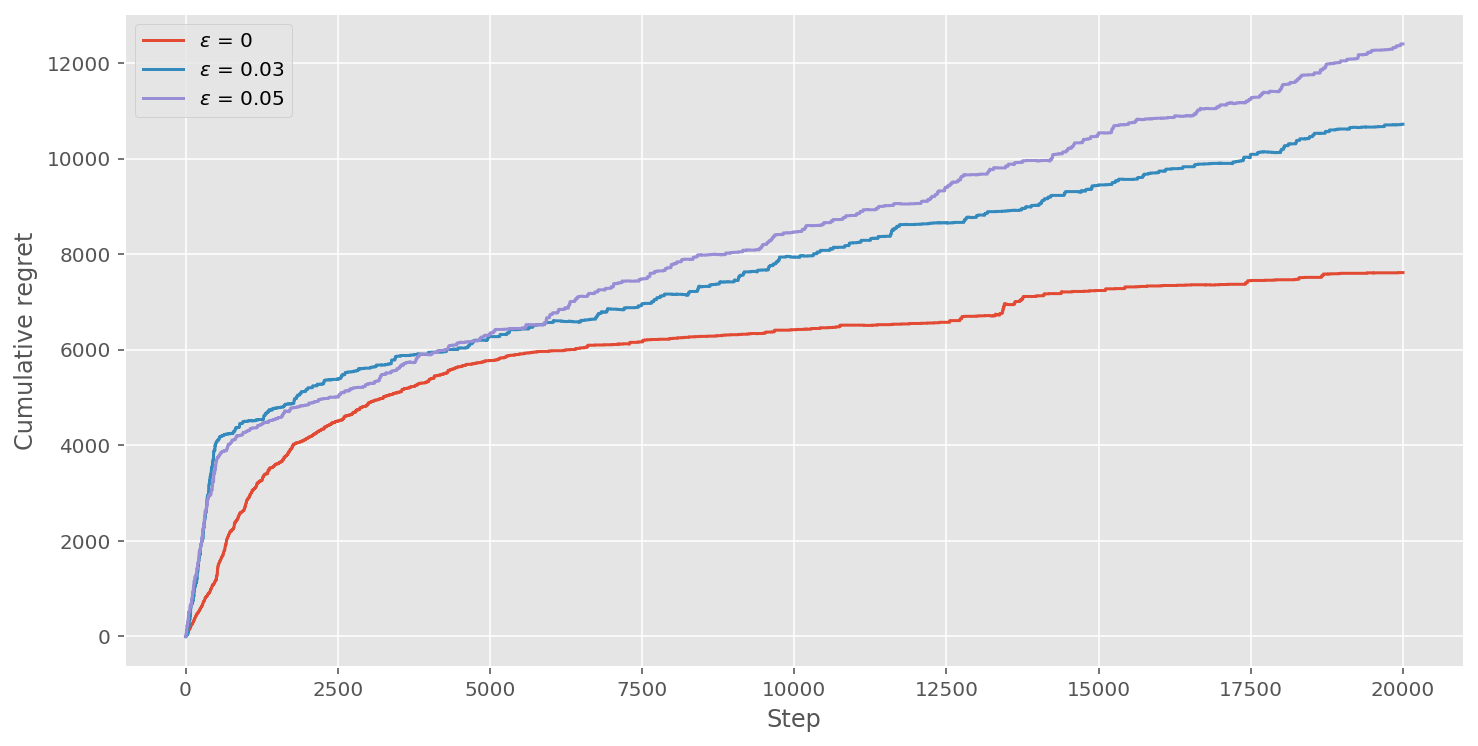

In [85]:
plt.figure(figsize=(12, 6))
for epsilon, regs in zip(epsilons, regrets):
    plt.plot(regs, label=r"$\epsilon$ = {}".format(epsilon))
plt.legend()
plt.xlabel('Step')
plt.ylabel('Cumulative regret')
plt.show()

In [74]:
epsilon = 0
net = nets.DeterministicRLNet(100, dim_input, dim_action_space)
agent_greedy = rl_utils.AgentGreedy(net, epsilon)
criterion = torch.nn.MSELoss()
rl_reg = nets.DeterministicRLReg(X_train_tensor, y_train_tensor, agent_greedy, buffer_size=4096, minibatch_size=64, burn_in=500, criterion=criterion)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-6)
rl_reg.train(20000, optimizer)

epoch:  1000 / 20000 | loss:        93.6 | regret:  4420 | training time: 00:00:00
epoch:  1500 / 20000 | loss:        48.3 | regret:  4635 | training time: 00:00:01
epoch:  2000 / 20000 | loss:        59.0 | regret:  4755 | training time: 00:00:02
epoch:  2500 / 20000 | loss:        19.3 | regret:  4850 | training time: 00:00:02
epoch:  3000 / 20000 | loss:         1.2 | regret:  4885 | training time: 00:00:03
epoch:  3500 / 20000 | loss:        23.1 | regret:  4960 | training time: 00:00:04
epoch:  4000 / 20000 | loss:         1.8 | regret:  4995 | training time: 00:00:05
epoch:  4500 / 20000 | loss:         9.3 | regret:  5060 | training time: 00:00:05
epoch:  5000 / 20000 | loss:         1.6 | regret:  5080 | training time: 00:00:06
epoch:  5500 / 20000 | loss:         0.2 | regret:  5105 | training time: 00:00:07
epoch:  6000 / 20000 | loss:         0.1 | regret:  5105 | training time: 00:00:08
epoch:  6500 / 20000 | loss:         0.0 | regret:  5110 | training time: 00:00:08
epoc

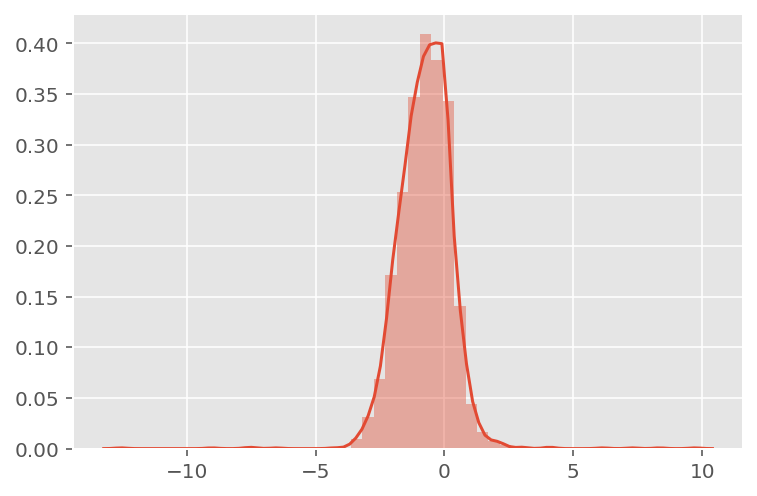

In [91]:
sns.distplot(net.weights_dist())

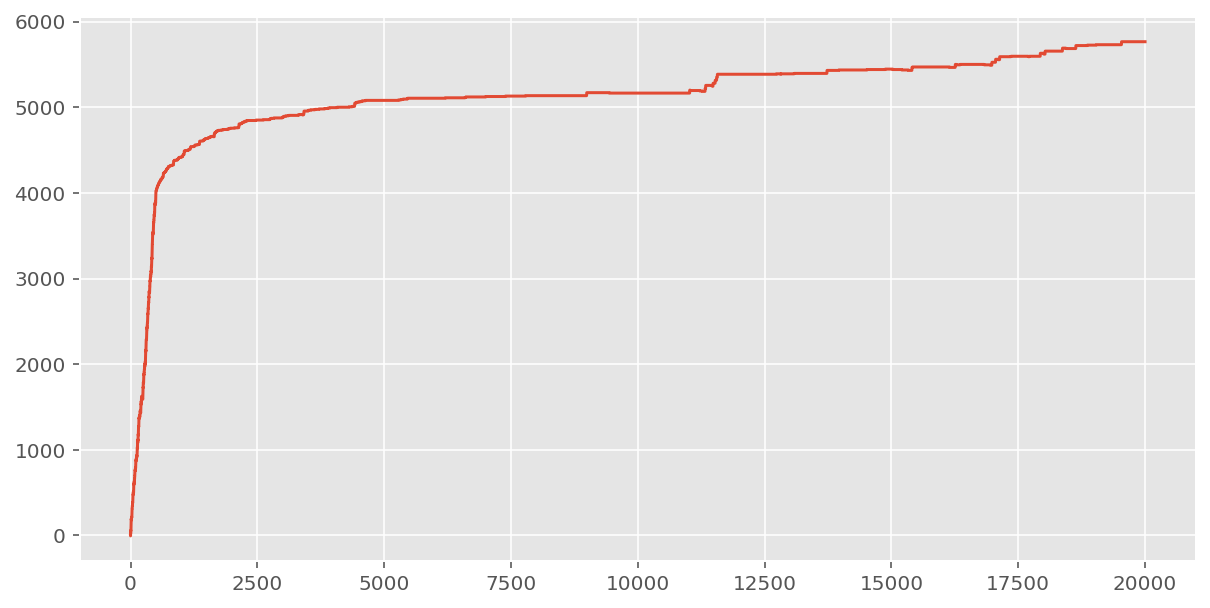

In [76]:
plt.figure(figsize=(10, 5))
plt.plot(rl_reg.hist['regret'])
plt.show()

In [87]:
prior_parameters = {'sigma1': np.exp(0), 'sigma2': np.exp(-6), 'pi': 0.5}
net = bb_net_rl.BayesBackpropRLNet(100, dim_input, dim_action_space, prior_parameters, sigma=0.02)
agent_bb = rl_utils.AgentBBNet(net, sample=2)
rl_reg = bb_net_rl.BayesRLReg(X_train_tensor, y_train_tensor, agent_bb, buffer_size=4096, minibatch_size=64, burn_in=500)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-6)
rl_reg.train(20000, optimizer)

epoch:  1000 / 20000 | loss: 181611296.0 | regret:  6045 | training time: 00:00:05
epoch:  1500 / 20000 | loss:  29734188.0 | regret:  8125 | training time: 00:00:10
epoch:  2000 / 20000 | loss:  17558304.0 | regret:  9770 | training time: 00:00:15
epoch:  2500 / 20000 | loss:  14780370.0 | regret: 11320 | training time: 00:00:20
epoch:  3000 / 20000 | loss:   5848377.0 | regret: 12970 | training time: 00:00:25
epoch:  3500 / 20000 | loss:   5514821.5 | regret: 14070 | training time: 00:00:31
epoch:  4000 / 20000 | loss:   6619012.0 | regret: 15160 | training time: 00:00:36
epoch:  4500 / 20000 | loss:   1636991.5 | regret: 16330 | training time: 00:00:41
epoch:  5000 / 20000 | loss:   1081164.0 | regret: 17310 | training time: 00:00:46
epoch:  5500 / 20000 | loss:    627374.9 | regret: 18215 | training time: 00:00:52
epoch:  6000 / 20000 | loss:   1908951.4 | regret: 19255 | training time: 00:00:57
epoch:  6500 / 20000 | loss:   3723542.2 | regret: 19880 | training time: 00:01:02
epoc

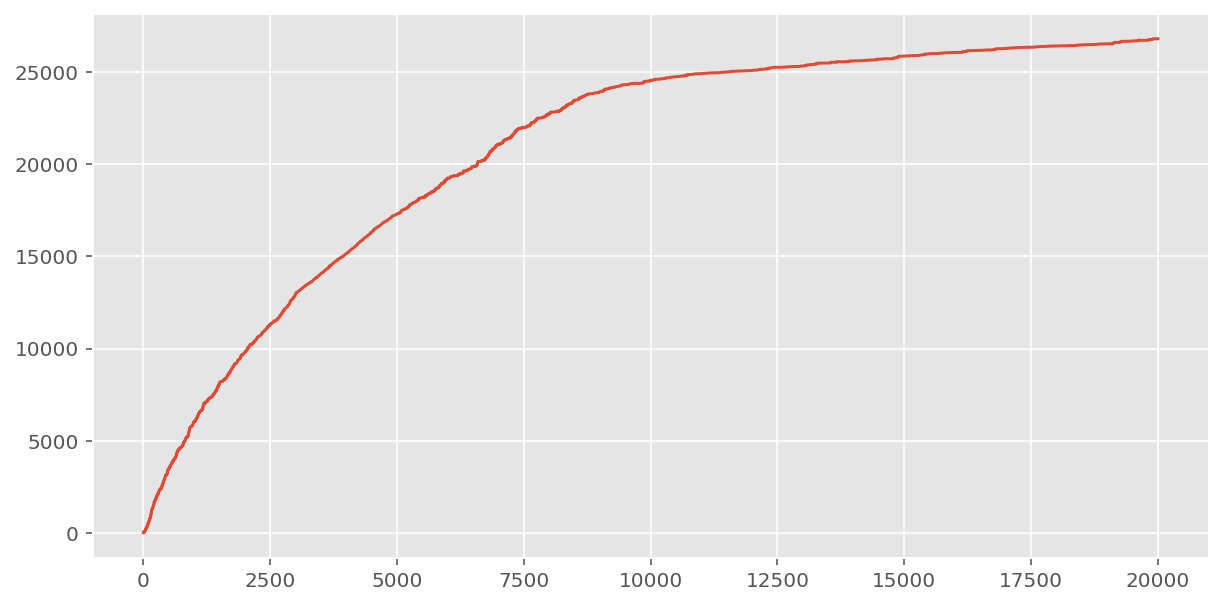

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(rl_reg.hist['regret'])
plt.show()

In [89]:
np.mean(net(X_test_tensor).squeeze().argmax(axis=1).numpy() == 1 - test_y)

0.9735384615384616

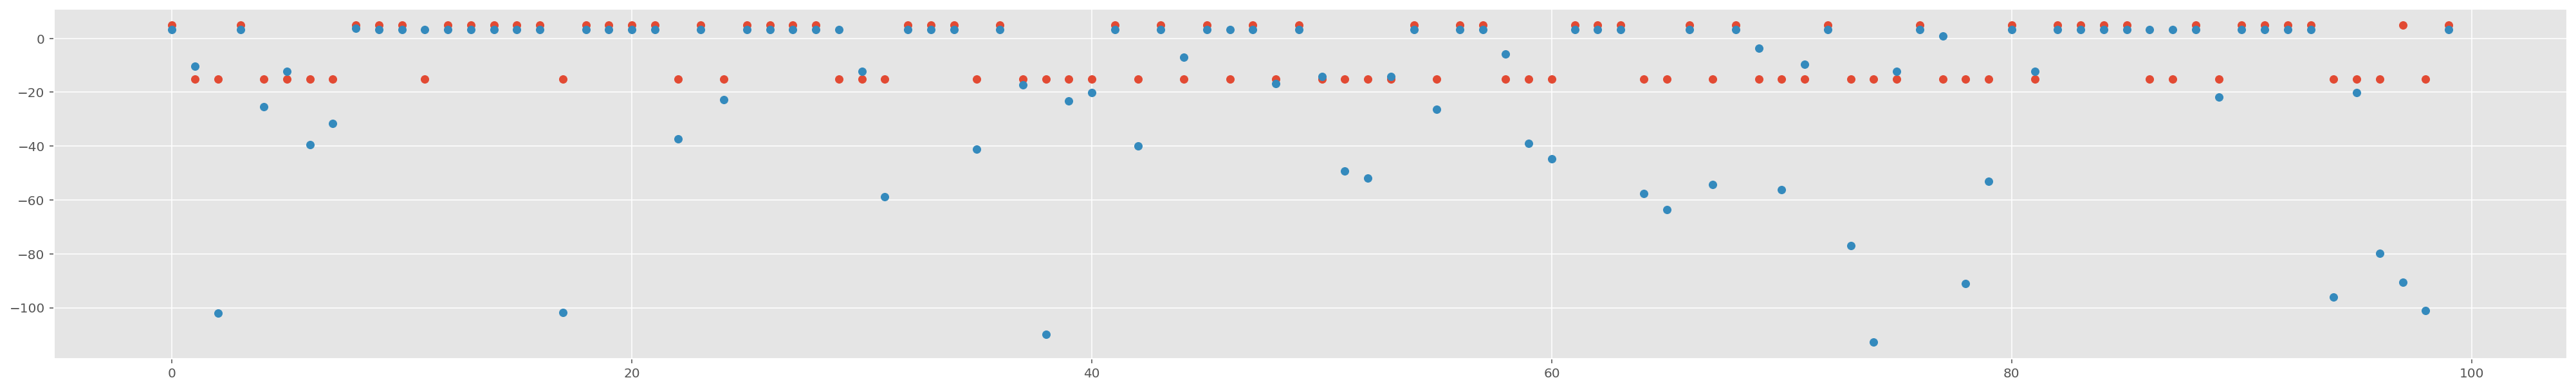

In [80]:
plt.figure(figsize=(35, 5))
plt.scatter(np.arange(100), - train_y[:100] * 20 + 5)
plt.scatter(np.arange(100), net(rl_reg.X_train).squeeze().detach().numpy()[:100, 1])

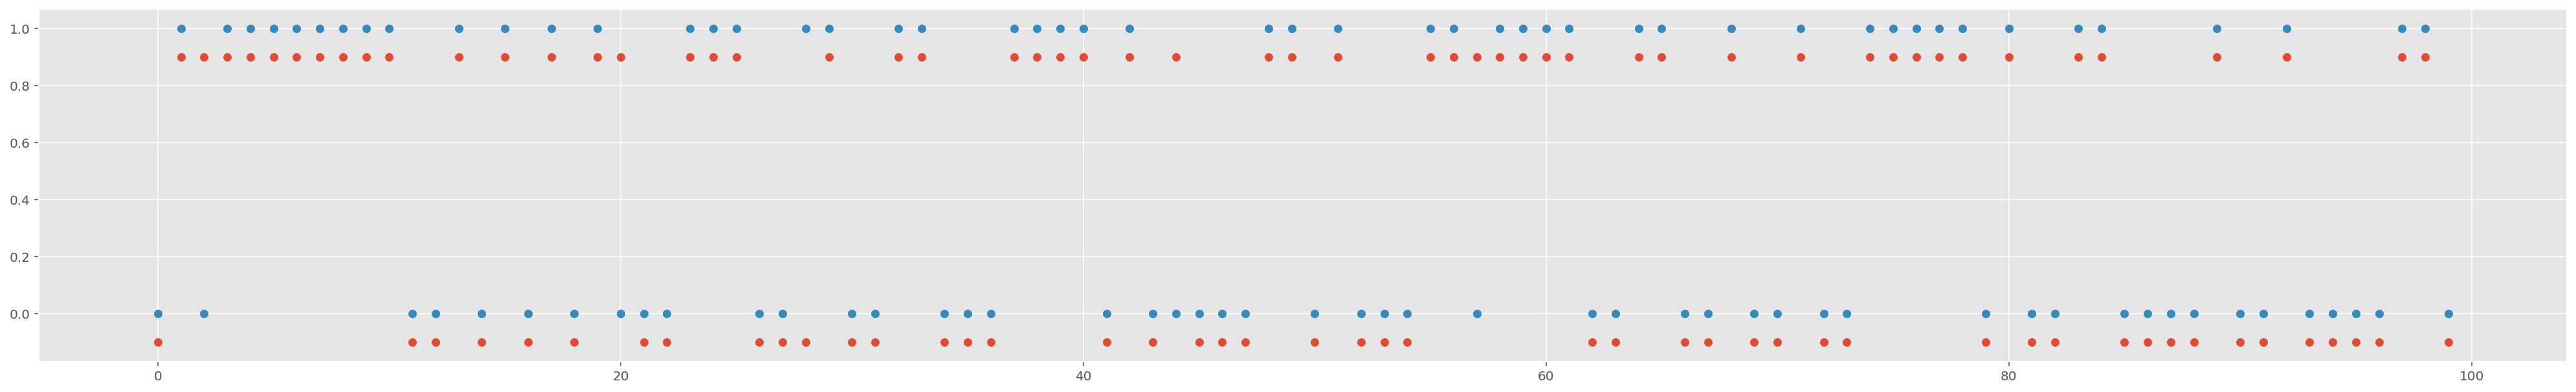

In [82]:
plt.figure(figsize=(35, 5))
plt.scatter(np.arange(100), test_y[:100] - 0.1)
plt.scatter(np.arange(100), 1 - net(X_test_tensor).squeeze().detach().numpy()[:100].argmax(axis=1))

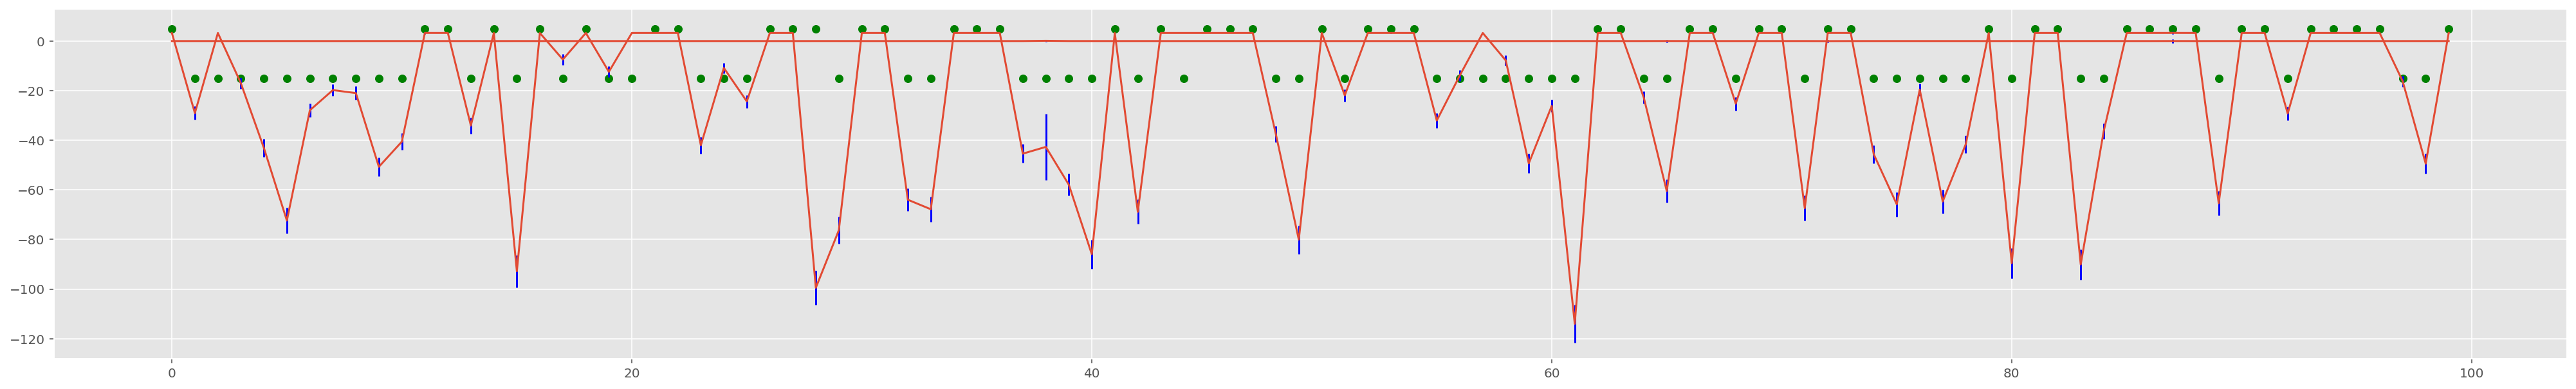

In [83]:
plt.figure(figsize=(35, 5))
N = 100
MC = 100
estimates = np.zeros((MC, N))
for i in range(MC):
    estimates[i] = net(X_test_tensor).squeeze().detach().numpy()[:N, 1]
plt.errorbar(np.arange(N), estimates.mean(axis=0), estimates.std(axis=0) * 3, ecolor='blue')

estimates = np.zeros((MC, N))
for i in range(MC):
    estimates[i] = net(X_test_tensor).squeeze().detach().numpy()[:N, 0]
plt.errorbar(np.arange(N), estimates.mean(axis=0), estimates.std(axis=0) * 3, ecolor='blue')

plt.scatter(np.arange(100), - test_y[:100] * 20 + 5, c='g')